# Assignment3
Repository Link: [Github](https://github.com/awakn123/CS6120NLP/tree/main)

Members: Yun Cao, Yue Liu, Nan Chen, Muyang Cheng

# Part 1: Data Preprocessing:
1.1 Load the dataset and perform initial exploration to understand its structure.

In [2]:
# data link: https://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Clothing_Shoes_and_Jewelry_5.json.gz
import pandas as pd
import json

data = []
with open('./Clothing_Shoes_and_Jewelry_5.json'
            , 'r') as f:
        for line in f:
            data.append(json.loads(line))

df = pd.DataFrame(data)
#df = df.sample(1000)
print(df.head())

       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  
0  Great tutu-  not cheaply made      1297468800  02 12, 2011  
1                    Very Cute!!      1358553600  01 19, 201

1.2 Clean the text data, including removing special characters, stopwords, applying lowercasing, and other tasks as
you deem necessary.

In [3]:
from nltk.corpus import stopwords
import nltk
import re
from symspellpy import SymSpell, Verbosity
from nltk.stem import WordNetLemmatizer
import pkg_resources
import inflect
import contractions
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
lemmatizer = WordNetLemmatizer()
p = inflect.engine()

def standardize_numbers(text):
    return ' '.join([p.number_to_words(word) if word.isdigit() else word for word in text.split()])

def handle_contractions(text):
    return contractions.fix(text)

def clean_text(text):
    text = str(text)
    # lowercase
    text = text.lower()
    # standardize
    text = standardize_numbers(text)
    # handle contractions
    text = handle_contractions(text)
    text = text.strip()
    # correct typos
    words = text.split()
    corrected_words = []
    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)
        corrected_words.append(suggestions[0].term if suggestions else word)
    text = ' '.join(corrected_words)
    # remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # remove stopwords
    words = [word for word in text.split() if word not in stop_words]
    # lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    # rejoin words
    text = ' '.join(words)
    return text

df["reviewText2"] = df["reviewText"].apply(lambda x: clean_text(x))
df["summary2"] = df["summary"].apply(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nanchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nanchen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Part 2: Word2Vec, fasttext embeddings
2.1 Create 100D vectors using both Word2Vec (CBOW and SkipGram separately), and fasttext algorithms

In [4]:
from gensim.models import Word2Vec
from gensim.models import FastText

sentences = [review.split() for review in df["reviewText2"]]

# Word2Vec CBOW Model
cbow_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)
#cbow_model.save("cbow_word2vec.model")

# Word2Vec Skip-gram Model
skipgram_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1)
#skipgram_model.save("skipgram_word2vec.model")

# FastText Model
fasttext_model = FastText(sentences, vector_size=100, window=5, min_count=1, sg=1)
#fasttext_model.save("fasttext.model")


2.2 Average the vectors to create new average vector columns in the df

In [5]:
import numpy as np
def get_average_word2vec_embeddings(review, model):
    words = review.split()
    embeddings = [model.wv[word] for word in words if word in model.wv.key_to_index]
    if len(embeddings) == 0:
        return [0]*model.vector_size
    return list(np.mean(embeddings, axis=0))

df_cbow_model = df.copy()
embeddings = df_cbow_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, cbow_model))
for i in range(cbow_model.vector_size):
    df_cbow_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i]) 
print(df_cbow_model.head())

df_skipgram_model = df.copy()
embeddings = df_skipgram_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, skipgram_model))
for i in range(skipgram_model.vector_size):
    df_skipgram_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
print(df_skipgram_model.head())

df_fasttext_model = df.copy()
embeddings = df_fasttext_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, fasttext_model))
for i in range(fasttext_model.vector_size):
    df_fasttext_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
print(df_fasttext_model.head())

/var/folders/sr/wj2mw1_s3qv1nywqkp54rk080000gn/T/ipykernel_50772/112724244.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cbow_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/sr/wj2mw1_s3qv1nywqkp54rk080000gn/T/ipykernel_50772/112724244.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cbow_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/sr/wj2mw1_s3qv1nywqkp54rk080000gn/T/ipykernel_50772/112724244.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usual

       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  \
0  Great tutu-  not cheaply made      1297468800  02 12, 2011   
1                    Very Cute!!      1358553600  01 19, 2

/var/folders/sr/wj2mw1_s3qv1nywqkp54rk080000gn/T/ipykernel_50772/112724244.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_skipgram_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/sr/wj2mw1_s3qv1nywqkp54rk080000gn/T/ipykernel_50772/112724244.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_skipgram_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/sr/wj2mw1_s3qv1nywqkp54rk080000gn/T/ipykernel_50772/112724244.py:18: PerformanceWarning: DataFrame is highly fragmented.  This 

       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  \
0  Great tutu-  not cheaply made      1297468800  02 12, 2011   
1                    Very Cute!!      1358553600  01 19, 2

/var/folders/sr/wj2mw1_s3qv1nywqkp54rk080000gn/T/ipykernel_50772/112724244.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fasttext_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/sr/wj2mw1_s3qv1nywqkp54rk080000gn/T/ipykernel_50772/112724244.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fasttext_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])


       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  \
0  Great tutu-  not cheaply made      1297468800  02 12, 2011   
1                    Very Cute!!      1358553600  01 19, 2

/var/folders/sr/wj2mw1_s3qv1nywqkp54rk080000gn/T/ipykernel_50772/112724244.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fasttext_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])


2.3 Perform EDA to analyze associations between vectors from the three methods above.


Analyze Words


In [ ]:
# Select 100 common words in three models
words = list(cbow_model.wv.key_to_index.keys())[:100]

# Extract the vectors for these common words from each model
cbow_vectors = np.array([cbow_model.wv[word] for word in words])
skipgram_vectors = np.array([skipgram_model.wv[word] for word in words])
fasttext_vectors = np.array([fasttext_model.wv[word] for word in words])

In [ ]:
# Visualization with t-SNE
#Use t-SNE to reduce the dimensionality of your word vectors to two or three dimensions.
#Plot the results to see how words cluster together.
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_word_vectors(model_vectors, words, title='Word Vectors Visualization'):
    tsne = TSNE(n_components=2, random_state=42)
    vectors_tsne = tsne.fit_transform(model_vectors)
    plt.figure(figsize=(12, 12))
    for i, word in enumerate(words):
        plt.scatter(vectors_tsne[i, 0], vectors_tsne[i, 1])
        plt.annotate(word, (vectors_tsne[i, 0], vectors_tsne[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.title(title)

visualize_word_vectors(cbow_vectors, words, 'CBOW t-SNE Visualization')
visualize_word_vectors(skipgram_vectors, words, 'Skip-gram t-SNE Visualization')
visualize_word_vectors(fasttext_vectors, words, 'FastText t-SNE Visualization')
plt.show()

In [ ]:
# Clustering with KMeans
# Apply clustering algorithms like K-Means on the word vectors.
# Analyze the clusters to see which words are grouped together by the model.
from sklearn.cluster import KMeans


def cluster_and_plot_words(model_vectors, common_words, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(model_vectors)
    cluster_map = {i: [] for i in range(n_clusters)}
    for word, label in zip(common_words, labels):
        cluster_map[label].append(word)

    colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
    plt.figure(figsize=(12, 12))
    
    for cluster_id in range(n_clusters):
        cluster_indices = [i for i, label in enumerate(labels) if label == cluster_id]
        cluster_points = model_vectors[cluster_indices]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_id], label=f'Cluster {cluster_id}', alpha=0.5)
    
    for i, word in enumerate(common_words):
        plt.text(model_vectors[i, 0], model_vectors[i, 1], word, fontsize=9)
    
    plt.title('Word Vectors Clustering')
    plt.legend()
    plt.show()
    
    return cluster_map

cbow_clusters = cluster_and_plot_words(cbow_vectors, words, n_clusters=10)
skipgram_clusters = cluster_and_plot_words(skipgram_vectors, words, n_clusters=10)
fasttext_clusters = cluster_and_plot_words(fasttext_vectors, words, n_clusters=10)

In [ ]:
# Similarity Analysis
# Compute the cosine similarity between word vectors
from scipy.spatial.distance import cosine

def compare_similarity(word1, word2, model1, model2, model3, model_name1='CBOW', model_name2='Skip-gram', model_name3='FastText'):
    similarity1 = 1 - cosine(model1.wv[word1], model1.wv[word2])
    similarity2 = 1 - cosine(model2.wv[word1], model2.wv[word2])
    similarity3 = 1 - cosine(model3.wv[word1], model3.wv[word2])
    print(f'{word1} & {word2} similarity in {model_name1}: {similarity1:.4f}')
    print(f'{word1} & {word2} similarity in {model_name2}: {similarity2:.4f}')
    print(f'{word1} & {word2} similarity in {model_name3}: {similarity3:.4f}')

compare_similarity('shirt', 'hoodie', cbow_model, skipgram_model, fasttext_model)


# Part 3: Sentiment Analysis

In [6]:


import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Convert the ratings to 0 for negative and 1 for positive
def convert_rating_to_sentiment(overall):
  if overall in [1, 2]:
      return 0  # Negative sentiment
  elif overall in [4, 5]:
      return 1  # Positive sentiment
  # Optionally handle unexpected cases, though all cases should be covered
  return None

def convertAndReduceDimension(df):
		df_filtered = df[df['overall'] != 3]
		df_filtered['sentiment'] = df_filtered['overall'].apply(convert_rating_to_sentiment)
		vector_cols = [col for col in df_filtered.columns if col.startswith('w2v_emb_')]
		X = df_filtered[vector_cols]
		scaler = StandardScaler()
		X_scaled = scaler.fit_transform(X)

		# Step 2: Apply PCA to retain 90% of the variance
		pca = PCA(n_components=0.9)  # n_components set to 0.9 means PCA will select the minimum number of components that retain 90% of the variance
		X_pca = pca.fit_transform(X_scaled)

		# Create a DataFrame with the PCA features
		df_pca = pd.DataFrame(X_pca, columns=[f'PCA_{i+1}' for i in range(X_pca.shape[1])])

		# Optionally, if you want to include the sentiment back into the PCA-transformed dataset
		df_pca['sentiment'] = df_filtered['sentiment'].values

		return df_pca
  
df_cbow = convertAndReduceDimension(df_cbow_model)
# Assuming df_final is your final DataFrame after PCA
X = df_cbow.drop('sentiment', axis=1).values  # Features
y = df_cbow['sentiment'].values  # Labels

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/sr/wj2mw1_s3qv1nywqkp54rk080000gn/T/ipykernel_50772/2830514594.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filtered['sentiment'] = df_filtered['overall'].apply(convert_rating_to_sentiment)
/var/folders/sr/wj2mw1_s3qv1nywqkp54rk080000gn/T/ipykernel_50772/2830514594.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment'] = df_filtered['overall'].apply(convert_rating_to_sentiment)


### Logistic Regression

I use GridSearchCV for hyperparameter tuning to find the best parameters for Logistic Regression model.

In this code, GridSearchCV performs an exhaustive search over the specified parameter grid, 
and best_params_ gives us the best parameters found during the search. Then can then use 
these parameters to train a new classifier.

For 'C', we choose the value in the list [0.001, 0.01, 0.1, 1, 10, 100, 1000]. For 'max_iter', we choose the value in the list [100, 500, 1000, 5000, 10000, 50000].  For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones. ‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.

When choosing the values for these parameters in GridSearchCV object. For the value of cv, a common choice is 5 or 10, but considering we have a large dataset, a smaller number can be used to save computational time. So, we choose 5. For "scoring", considering we’re dealing with a classification problem, we use ‘accuracy’. For other parameters like 'n_jobs', 'verbose', 'return_train_score', we use the default values.


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 500, 1000, 5000, 10000, 50000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Create a Logistic Regression model
model = LogisticRegression()

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print(f"Best parameters: {best_params}")




/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
630 fits failed out of a total of 2100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
210 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/

Best parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


We took 25 mins to get the best parameters.
```
param_space = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 500, 1000, 5000, 10000, 50000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
```
The best params are: 
```
{'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
```

We revise our param_grid to improve the best parameters further so that we can avoid overfitting and underfitting. We choose 'l2' for 'penalty' and 'lbfgs' for 'solver'. For 'C', we generate 10 numbers between 0.01 and 1. For 'max_iter', we generate random integers between 50 and 250.

In [23]:
# Fit the model with the best parameters to the training data
model_best = LogisticRegression(**best_params)
model_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_best.predict(X_val)

# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)  # Handling division by zero for classes with no predictions
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9265674407363397
Precision: 0.9186826145148944
Recall: 0.9265674407363397
F1 Score: 0.9187615596666782


We got the evaluation metrics.
```
    Accuracy: 0.9265674407363397
    Precision: 0.9186826145148944
    Recall: 0.9265674407363397
    F1 Score: 0.9187615596666782
```

In [24]:

# Define the parameter grid
param_grid = {
    'C': np.logspace(-2, 0, 10),
    'penalty': ['l2'],
    'max_iter': np.random.randint(50, 251, size=10),
    'solver': ['lbfgs']
}

# Create a Logistic Regression model
model = LogisticRegression()

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print(f"Best parameters: {best_params}")


Best parameters: {'C': 0.1291549665014884, 'max_iter': 88, 'penalty': 'l2', 'solver': 'lbfgs'}


In [25]:
# Fit the model with the best parameters to the training data
model_best = LogisticRegression(**best_params)
model_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_best.predict(X_val)

# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)  # Handling division by zero for classes with no predictions
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9265875813175968
Precision: 0.9187091269813016
Recall: 0.9265875813175968
F1 Score: 0.9187888187481864


We got the evaluation metrics.
```
    Accuracy: 0.9265875813175968
    Precision: 0.9187091269813016
    Recall: 0.9265875813175968
    F1 Score: 0.9187888187481864
```
The performance is good. The second results has minor improvement compared to the first one and the running time for getting the best parameters is much less than the first one. In this case, after tuning hyperparameters, we found that 
```
    Best parameters: {'C': 0.1291549665014884, 'max_iter': 88, 'penalty': 'l2', 'solver': 'lbfgs'}
```

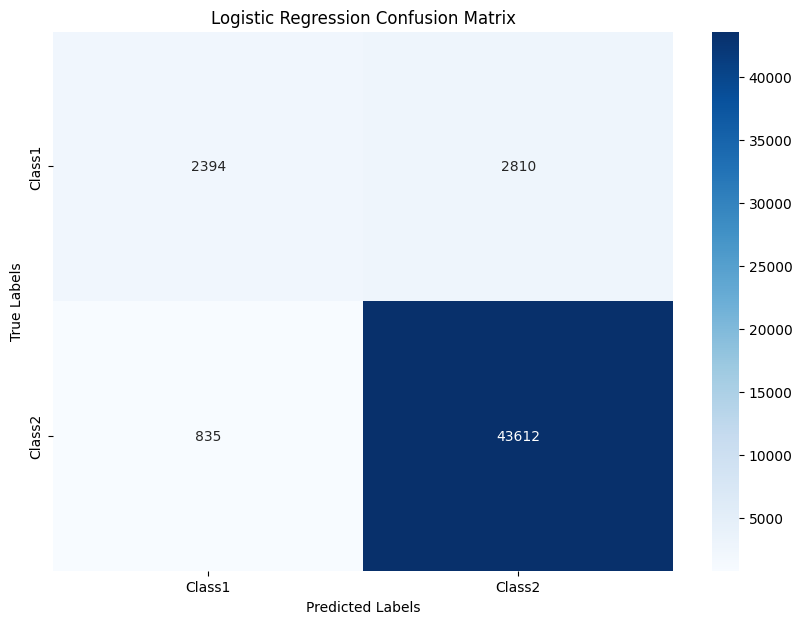

[[ 2394  2810]
 [  835 43612]]


In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_test, pred, title):
	conf_matrix = confusion_matrix(y_test, pred)  # Use predictions_binary or the equivalent for your case
	plt.figure(figsize=(10, 7))
	sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Class1', 'Class2'], yticklabels=['Class1', 'Class2'])
	plt.xlabel('Predicted Labels')
	plt.ylabel('True Labels')
	plt.title(title)
	plt.show()
	print(conf_matrix)


plot_confusion_matrix(y_val, y_pred, "Logistic Regression Confusion Matrix")

